In [1]:
!pip install ipynb
!pip install nbimporter
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve, auc
import seaborn as sns
import plotly.express as px
sns.set(palette='rainbow', context='talk')
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import time

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel, FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.algorithms.state_fidelities import ComputeUncompute
"""
import nbimporter
from ipynb.fs.full.EDA import vowelData
from ipynb.fs.full.EDA import irisData
from ipynb.fs.full.EDA import breastcancerData"""



[notice] A new release of pip available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


'\nimport nbimporter\nfrom ipynb.fs.full.EDA import vowelData\nfrom ipynb.fs.full.EDA import irisData\nfrom ipynb.fs.full.EDA import breastcancerData'

In [2]:
%run "EDA.ipynb"


[notice] A new release of pip available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


### Functions

In [3]:
reps = 4
accurancy = []

In [4]:
def split_inandout(outlier,inlier,target, df_,frac_out):
    
    df = df_.copy()
    #class_label = target
    out_classes = pd.DataFrame()
    #Select the class you want to be outlier
    for out in outlier:
        out_class = out
        outliers_samples = df[df.target == out_class]
        outliers_samples = outliers_samples.sample(frac = frac_out)
        out_classes = pd.concat([out_classes, outliers_samples], ignore_index=False).sort_index()
        #print(out_classes.shape)
    
    #print(out_classes.shape)
    in_class = inlier
    df = df_.copy()
    inlier_samples = df[df.target == in_class]

    # Concatenate the modified outliers samples with the original inlier samples
    y = pd.concat([inlier_samples.target, out_classes.target], ignore_index=False).sort_index()
    y =[1 if i==inlier else 0 for i in y]
    print(Counter(y))
    x = pd.concat([inlier_samples.drop(columns=target), out_classes.drop(columns=target)], ignore_index=False).sort_index()

    return x,y

In [5]:
def split_TestTrain_normalize(x,y):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43,stratify=y)

        # Check the number of records
    print('The number of records in the training dataset is', X_train.shape[0])
    print('The number of records in the test dataset is', X_test.shape[0])
    print(Counter(y_train))
    
    # Assuming your dataset is a 2D array or a pandas DataFrame
    # Initialize the scaler
    #scaler = StandardScaler()
    #scaler = MinMaxScaler()
    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [6]:
def runAll_kernelsSVM(X_train,X_test,y_train,y_test, gamma,kernel,nu):
    
    #ds1_f1 = []
    predictions = []
    predictionsTrains = []

    
    # Train the one class support vector machine (SVM) model
    one_class_svm = OneClassSVM(nu=nu,kernel = kernel,gamma=gamma).fit(X_train)
        
    # Predict the anomalies
    test_prediction = one_class_svm.predict(X_test)
    prediction = [1 if i==1 else 0 for i in test_prediction]
    print("{} The accurnacy is {}".format(kernel,accuracy_score(y_test, prediction)))
    #ds1_f1.append(f1_score(y_test, prediction))
    
    accurancy.append(accuracy_score(y_test, prediction))
    train_prediction = one_class_svm.predict(X_train)
    predictionTrain = [1 if i==1 else 0 for i in train_prediction]
    

    return prediction,predictionTrain

In [7]:
def scatterPlot(X_test,y_test,test_prediction,filename,feature1,feature2):    
# Put the testing dataset and predictions in the same dataframe
    X_test_ = X_test.copy()
    y_test_ = y_test.copy()
    df_test = pd.DataFrame(X_test_)
    df_test['y_test'] = np.array(y_test_)
    df_test['one_class_svm_prediction'] = test_prediction
    # Visualize the actual and predicted anomalies
    fig, ax = plt.subplots(figsize=(8, 6))

    # Well-classified samples
    well_classified = df_test[df_test['y_test'] == df_test['one_class_svm_prediction']]
    ax.scatter(well_classified[feature1], well_classified[feature2], c='green', label='Well Classified')

    # Wrongly classified samples
    wrong_classified = df_test[df_test['y_test'] != df_test['one_class_svm_prediction']]
    ax.scatter(wrong_classified[feature1], wrong_classified[feature2], c='red', label='Wrong Classification')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Well Classified vs Wrong Classification')
    ax.legend()

    plt.show()

In [8]:
def recallPlot(y_test,test_prediction,filename):    
    
    #labels = y_test
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, test_prediction)

    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    #display plot
    #plt.show()
    plt.savefig(filename)

In [9]:
def RocCurve_plot(y_train, y_test, train_prediction,test_prediction,filename):
    
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, test_prediction)
    plt.grid()
    plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0,1],[0,1],'g--')
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC(ROC curve)")
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    #plt.show()
    
    plt.savefig(filename)

# IRIS DATASET

In [10]:
dataset_iris, x ,y = irisData ()
n_dim = x.shape[1]
target = 'target'
print("The dataset selected has shape: " + str(dataset_iris.shape) + " and for each class "+ str(Counter(dataset_iris[target])))

The dataset selected has shape: (150, 5) and for each class Counter({0: 50, 1: 50, 2: 50})


## Apply OCC-SVM

### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [11]:
out_class = [0,2]
in_class = 1

x_,y_ = split_inandout(out_class,in_class,target,dataset_iris,0.1)
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x_,y_)

Counter({1: 50, 0: 10})
The number of records in the training dataset is 42
The number of records in the test dataset is 18
Counter({1: 35, 0: 7})


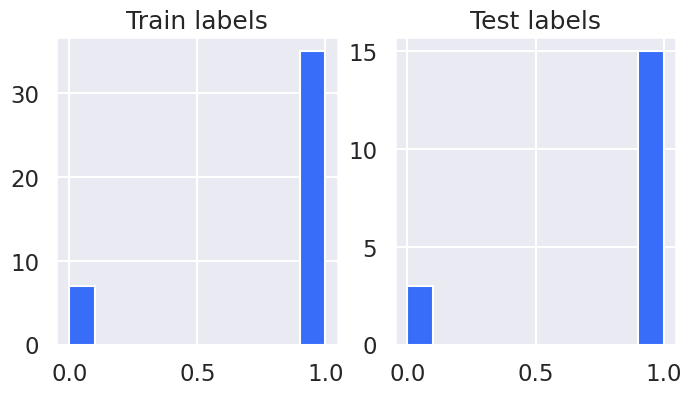

In [12]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

### Quantum Kernel

In [13]:
num_qubits = n_dim
zz_map = ZFeatureMap(feature_dimension=num_qubits, reps=reps, insert_barriers=True)
#zz_map = ZZFeatureMap(feature_dimension=num_qubits, reps=reps, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_circuit = zz_kernel.construct_circuit(X_train[0], X_train[1])
# zz_circuit.decompose().decompose().draw(output='mpl')

In [14]:
start_time = time.time()
kernels = zz_kernel.evaluate
prediction,train_prediction = runAll_kernelsSVM(X_train, X_test,y_train, y_test,0.1,kernels,0.2)
print("Execution time: ", time.time() - start_time)

<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f7a28d71ba0>> The accurnacy is 0.4444444444444444
Execution time:  1.5527188777923584


### Evaluation Metrics

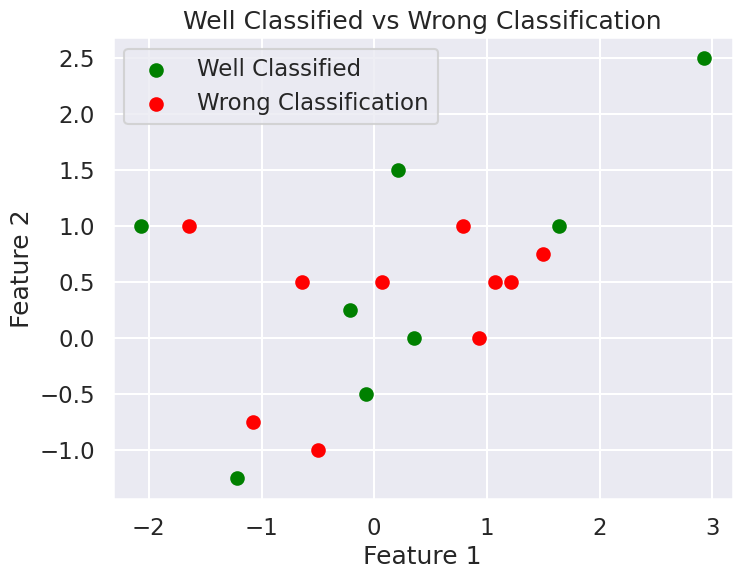

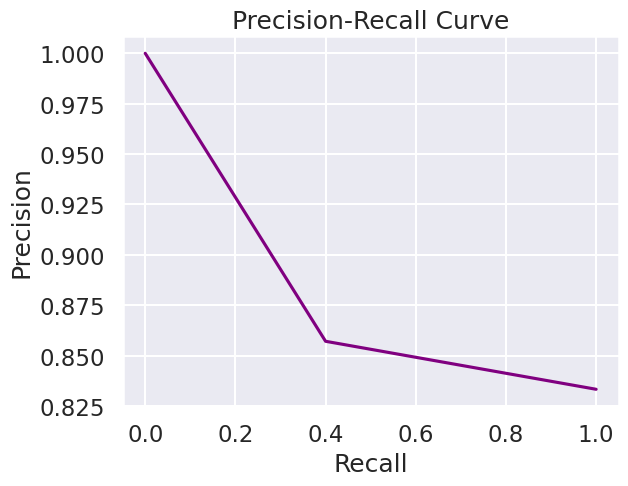

In [15]:
test_prediction = prediction
train_prediction = train_prediction
filename = '../figures/Quantum_IrisData'

scatterPlot(X_test,y_test,test_prediction,filename+'_scatterPlot',0,1)
recallPlot(y_test,test_prediction,filename+'_recallPlot')


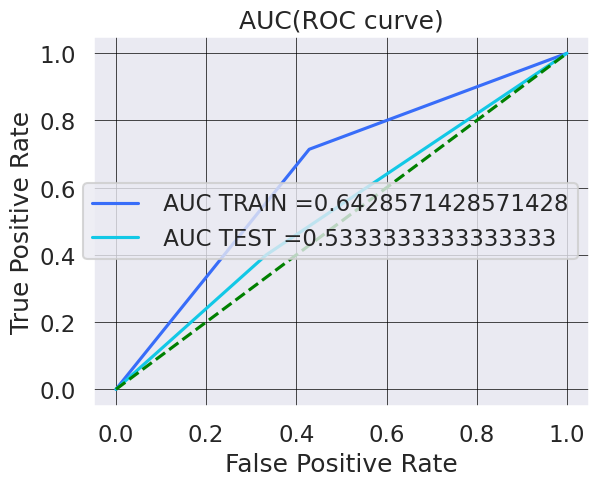

In [16]:
RocCurve_plot(y_train, y_test, train_prediction,test_prediction,filename+'_ROCplot')

# VOWEL DATASET

In [17]:
vowelDataset, x ,y = vowelData ()
vowelDataset = vowelDataset.rename(columns={'feature12':'target'})
n_dim = x.shape[1]
#for vowels dataset
target = 'target'

print("The dataset selected has shape: " + str(vowelDataset.shape) + " and for each class "+ str(Counter(vowelDataset[target])))

The dataset selected has shape: (990, 13) and for each class Counter({0: 90, 1: 90, 2: 90, 3: 90, 4: 90, 5: 90, 6: 90, 7: 90, 8: 90, 9: 90, 10: 90})


## Apply OCC-SVM

### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [18]:
out_class = [0,5,6,7,9]
in_class = 1
x,y = split_inandout(out_class,in_class,target,vowelDataset,0.05)
# Train test split
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x,y)


Counter({1: 90, 0: 20})
The number of records in the training dataset is 77
The number of records in the test dataset is 33
Counter({1: 63, 0: 14})


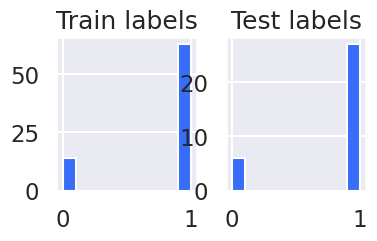

In [19]:
fig, ax = plt.subplots(1,2, figsize=(4,2))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

### Quantum Kernel

In [20]:
num_qubits = n_dim
zz_map = ZFeatureMap(feature_dimension=num_qubits, reps=reps, insert_barriers=True)
#zz_map = ZZFeatureMap(feature_dimension=num_qubits, reps=reps, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_circuit = zz_kernel.construct_circuit(X_train[0], X_train[1])
# zz_circuit.decompose().decompose().draw(output='mpl')

In [21]:
start_time = time.time()
kernels = zz_kernel.evaluate
prediction,train_prediction = runAll_kernelsSVM(X_train, X_test,y_train, y_test,0.5,kernels,0.2)
print("Execution time: ", time.time() - start_time)

<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f79e416a3e0>> The accurnacy is 0.18181818181818182
Execution time:  5.6938862800598145


### Evaluation Metrics

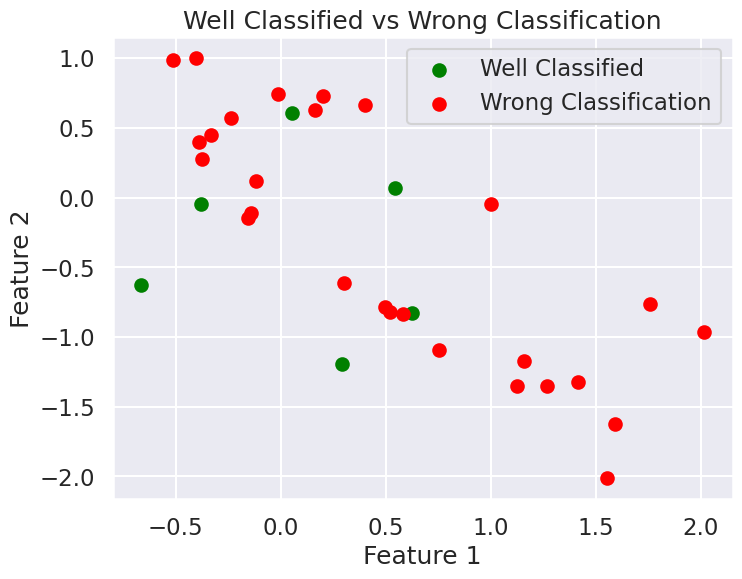

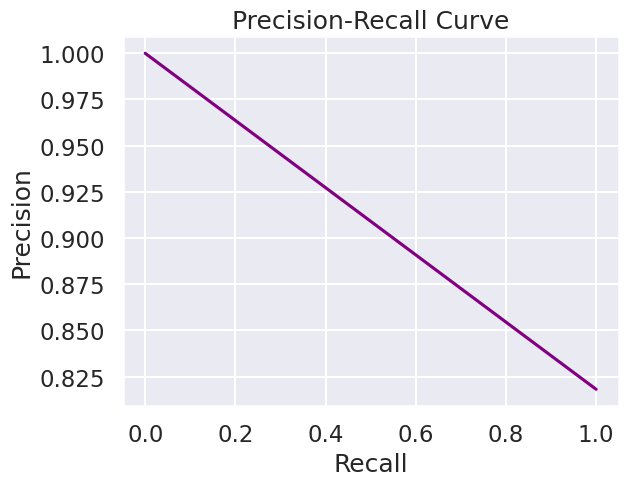

In [22]:
test_prediction = prediction
train_prediction = train_prediction
filename = '../figures/Quantum-vowelData'

scatterPlot(X_test,y_test,test_prediction,filename+'_scatterPlot',4,7)
recallPlot(y_test,test_prediction,filename+'_recallPlot')


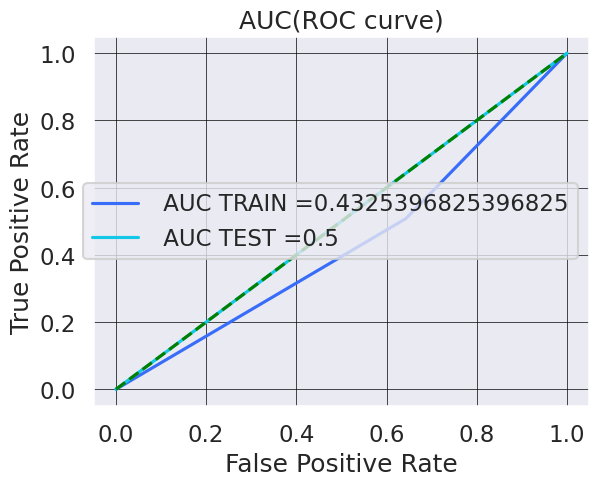

In [23]:
RocCurve_plot(y_train, y_test, train_prediction,test_prediction,filename+'_ROCplot')

# BREAST CANCER DATASET

In [24]:
breast_dataset, x ,y = breastcancerData()
target = 'target'

print("The dataset selected has shape: " + str(breast_dataset.shape) + " and for each class "+ str(Counter(breast_dataset[target])))

The dataset selected has shape: (569, 31) and for each class Counter({1: 357, 0: 212})


## Apply OCC-SVM

### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [25]:
out_class = [1]
in_class = 0
x_,y_ = split_inandout(out_class,in_class,target,breast_dataset,0.1)
# Train test split
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x_,y_)


Counter({1: 212, 0: 36})
The number of records in the training dataset is 173
The number of records in the test dataset is 75
Counter({1: 148, 0: 25})


In [26]:
# Reduce dimensions (the dataset now has a dimensionality of 31 attributes)
n_dim = 12 #number of qubits we want to use
pca = PCA(n_components=n_dim).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
num_qubits = n_dim

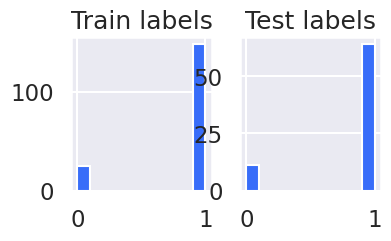

In [27]:
fig, ax = plt.subplots(1,2, figsize=(4,2))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

### Quantum Kernel

In [28]:
zz_map = ZFeatureMap(feature_dimension=num_qubits, reps=reps, insert_barriers=True)
#zz_map = ZZFeatureMap(feature_dimension=num_qubits, reps=reps, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_circuit = zz_kernel.construct_circuit(X_train[0], X_train[1])
# zz_circuit.decompose().decompose().draw(output='mpl')

In [29]:
start_time = time.time()
kernels = zz_kernel.evaluate
prediction,train_prediction = runAll_kernelsSVM(X_train, X_test,y_train, y_test,0.5,kernels,0.1)
print("Execution time: ", time.time() - start_time)

<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f79e4147d90>> The accurnacy is 0.16
Execution time:  12.08997917175293


### Evaluation Metrics

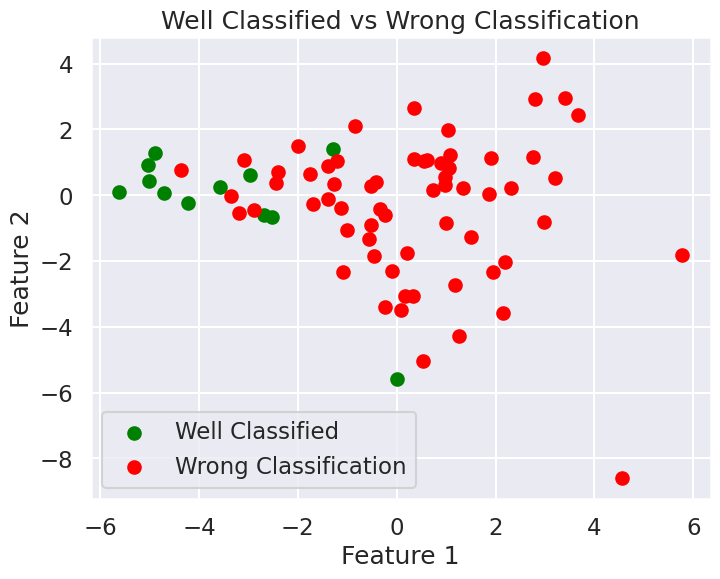

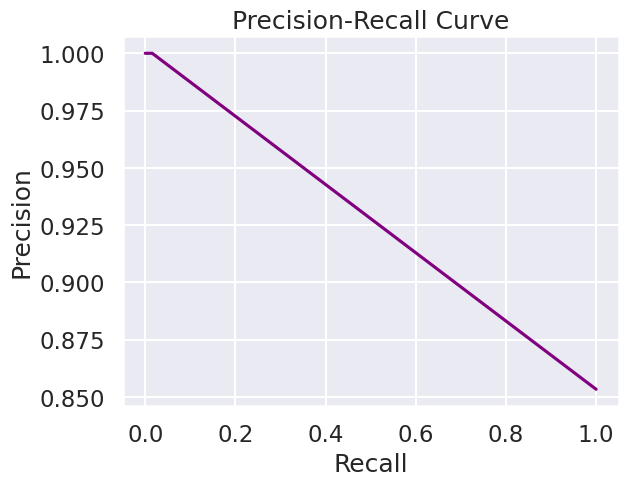

In [30]:
test_prediction = prediction
train_prediction = train_prediction
filename = '../figures/Quantum_BreastData'

scatterPlot(X_test,y_test,test_prediction,filename+'_scatterPlot',0,1)
recallPlot(y_test,test_prediction,filename+'_recallPlot')

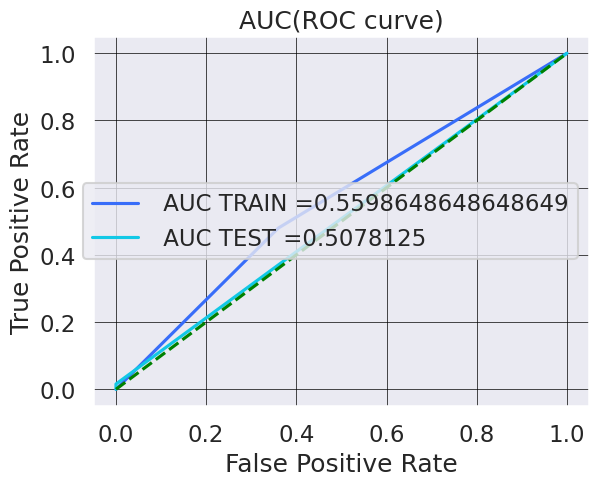

In [31]:
RocCurve_plot(y_train, y_test, train_prediction,test_prediction,filename+'_ROCplot')

In [32]:
accurancy

[0.4444444444444444, 0.18181818181818182, 0.16]